First I fix some typos in the company names:

    -   "Group 1 Automative" -> "Group 1 Automotive"
    -   "Penske Automative Group" -> "Penske Automotive Group"
    -   "Asbury Automative" -> "Asbury Automotive"
    
Most of the company names are in the automotive industry but there are confusion in retrieved data, so I make the following assumptions:

    -   "CarMax" -> "CarMax Inc" (not to be confused with "CarMax Auto Owner Trust" since their 10-K report lack the Item 7 as in requirements)
    -   "Ford Motors" -> "Ford Motor Co" (not to be confused with "Ford Motor Credit")
    -   "Carvana" -> "Carvana Co" (not to be confused with "Carvana Auto Receivables Trust")
    -   "Harley-Davidson" -> "Harley-Davidson Inc" (not to be confused with "Harley-Davidson Motorcycle Trust")

### Notes
Some of the codes below requires the SEC API-KEY to function which has limited used time, so creating a SEC API account and getting a new API-KEY for some function is advisable.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd "/content/drive/MyDrive/sec_filings"

/content/drive/MyDrive/sec_filings


### Import and download neccessary libraries

In [ ]:
!pip install sec-api

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install textblob

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
import pandas as pd
import glob
import regex as re
from bs4 import BeautifulSoup
import numpy as np
import json
import os
import matplotlib.pyplot as plt
from scipy import stats

### Annual reports downloading

The downloaded txt files are saved in the folder italicized text "filings/"

In [ ]:
from download_sec_filings import download_filings

In [ ]:
missing_annual_reports = download_filings()

with open("missing_annual_reports_list.txt", "w") as f:
    f.write("\n".join(missing_annual_reports))

Check in the downloaded txt file and the SEC documentations give an insights that these files are bloated with a lot of different reports inside this annual reports. The 10-K reports that we focus on are between the start of the document and \</Document> tags. Extracting this report section will make it easier to navigate the documents.And use BeautifulSoup to make the file readable.

In [ ]:
for file in glob.glob('filings/*'):
    with open(file, "r+") as f:
        content = f.read()
        document_end = re.search(r"(?i)</DOCUMENT>", content)
        new_document = content[:document_end.end()]
        new_document = new_document.encode('ascii', 'ignore').decode('ascii')

        soup = BeautifulSoup(new_document, "html.parser")
        new_document = soup.prettify()
        
        f.seek(0)
        f.write(new_document)
        f.truncate()

### Extract information

In [4]:
from extract_info import extract_info

In [7]:
company_filings_df = pd.read_csv("company_filings.csv")
company_info_df = pd.DataFrame(columns=['Company', 'Document', 'CIK', 'Ticker', 'Fiscal_year', 'Reporting_date', 'Filing_date', 'Location', 'Industry'])

for index, row in company_filings_df.iterrows():
    company_infos = extract_info("filings/" + row['Text'])
    company_infos['Company'] = row['Company']
    print(row['Company'])
    company_info_df = pd.concat([company_info_df, pd.DataFrame([company_infos])], ignore_index=True)

company_info_df.to_csv("company_infos.csv")

Ford Motor Co
Carvana Co
Avis Budget
FREYR Battery
BorgWarner Inc.
Tesla
Rivian
Microvast Holdings
Polaris
Lucid
CarMax Inc
AutoNation
American Axle
Group 1 Automotive
APTIV
Harley-Davidson Inc
Tenneco
Fisker
Penske Automotive Group
Lear
Lithia Motors
Quantumscape
Adient
General Motors
Visteon
Hertz
Asbury Automotive


### Extract section from txt file
Due to the minor differences between documents, some documents lack one or two sections compare with others, and there are also typos and mistructuring, so I implement a simple parser with fuzzy-match from regex to search for the start and end of each sections. The result json files are saved in the folder \"sections/\".

In [ ]:
from segment_section import segment_section

for file_name in glob.glob("filings/*"):
    print(file_name)
    segment_section(os.path.basename(file_name)) 

filings/0001213900-22-015871.txt
filings/0000037996-22-000013.txt
filings/0000804269-22-000004.txt
filings/0000350698-22-000025.txt
filings/0000842162-22-000009.txt
filings/0000908255-22-000009.txt
filings/0001019849-22-000013.txt
filings/0000723612-22-000006.txt
filings/0000793952-22-000014.txt
filings/0000950170-22-000796.txt
filings/0001023128-22-000042.txt
filings/0001031203-22-000007.txt
filings/0000950170-22-002330.txt
filings/0001024725-22-000005.txt
filings/0001144980-22-000079.txt
filings/0001493152-22-009199.txt
filings/0001213900-22-011331.txt
filings/0001111335-22-000014.txt
filings/0001170010-22-000017.txt
filings/0001062231-22-000008.txt
filings/0001628280-22-002730.txt
filings/0001670541-21-000133.txt
filings/0001874178-22-000008.txt
filings/0001690820-22-000080.txt
filings/0001521332-22-000010.txt
filings/0001657853-22-000012.txt
filings/0001720990-22-000010.txt


### Extract sentiment for given words
My approach to this problem is calculating the polarity of the sentences that contain given words from the combinations of all sections of every companies in the potential lists. The result csv files are saved in the folder \"sentiments/\"

In [4]:
from extract_sentiment import extract_sentiment 

In [5]:
words = ['lithium', 'oil', 'supply chain', 'steel', 'aluminum']

In [6]:
for file_path in glob.glob("sections/*"):
    print(file_path)
    sentiment_df = extract_sentiment(file_path, words)
    sentiment_csv_name = f"{os.path.basename(file_path).split('.')[0]}.csv" 
    sentiment_df.to_csv(f"sentiments/{sentiment_csv_name}")

sections/0001213900-22-015871.json
sections/0000037996-22-000013.json
sections/0000804269-22-000004.json
sections/0000350698-22-000025.json
sections/0000842162-22-000009.json
sections/0000908255-22-000009.json
sections/0001019849-22-000013.json
sections/0000723612-22-000006.json
sections/0000793952-22-000014.json
sections/0000950170-22-000796.json
sections/0001023128-22-000042.json
sections/0001031203-22-000007.json
sections/0000950170-22-002330.json
sections/0001024725-22-000005.json
sections/0001144980-22-000079.json
sections/0001493152-22-009199.json
sections/0001213900-22-011331.json
sections/0001111335-22-000014.json
sections/0001170010-22-000017.json
sections/0001062231-22-000008.json
sections/0001628280-22-002730.json
sections/0001670541-21-000133.json
sections/0001874178-22-000008.json
sections/0001690820-22-000080.json
sections/0001521332-22-000010.json
sections/0001657853-22-000012.json
sections/0001720990-22-000010.json


### Exploratory Data Analysis

In [4]:
sentiment_data = pd.DataFrame(columns=["Document", "Word", "Sentence", "Polarity"])
for file_name in glob.glob("sentiments/*"):
    df = pd.read_csv(file_name)
    df["Document"] = os.path.basename(file_name).split(".")[0]
    sentiment_data = pd.concat([sentiment_data, df], ignore_index=True)

We explore further the sentiment data related to each words.

#### Lithium

For lithium the data show a sentiment mean of 0.058 with 131 records.

In [27]:
lithium_sentiments = sentiment_data.loc[sentiment_data["Word"] == "lithium","Polarity"]
lithium_sentiments.describe()

count    131.000000
mean       0.058392
std        0.174673
min       -0.500000
25%       -0.071429
50%        0.062500
75%        0.163333
max        0.600000
Name: Polarity, dtype: float64

About 30% of the sentiment record shows negative views related to lithium. While 54% shows postive views.

In [41]:
negative = stats.percentileofscore(lithium_sentiments, -0.05)
positive = 100 - stats.percentileofscore(lithium_sentiments, 0.05)
neutral = 100 - negative - positive
print("Negative: ", negative)
print("Positive: ", positive)
print("Neutral: ", neutral)

Negative:  30.53435114503817
Positive:  54.19847328244275
Neutral:  15.26717557251908


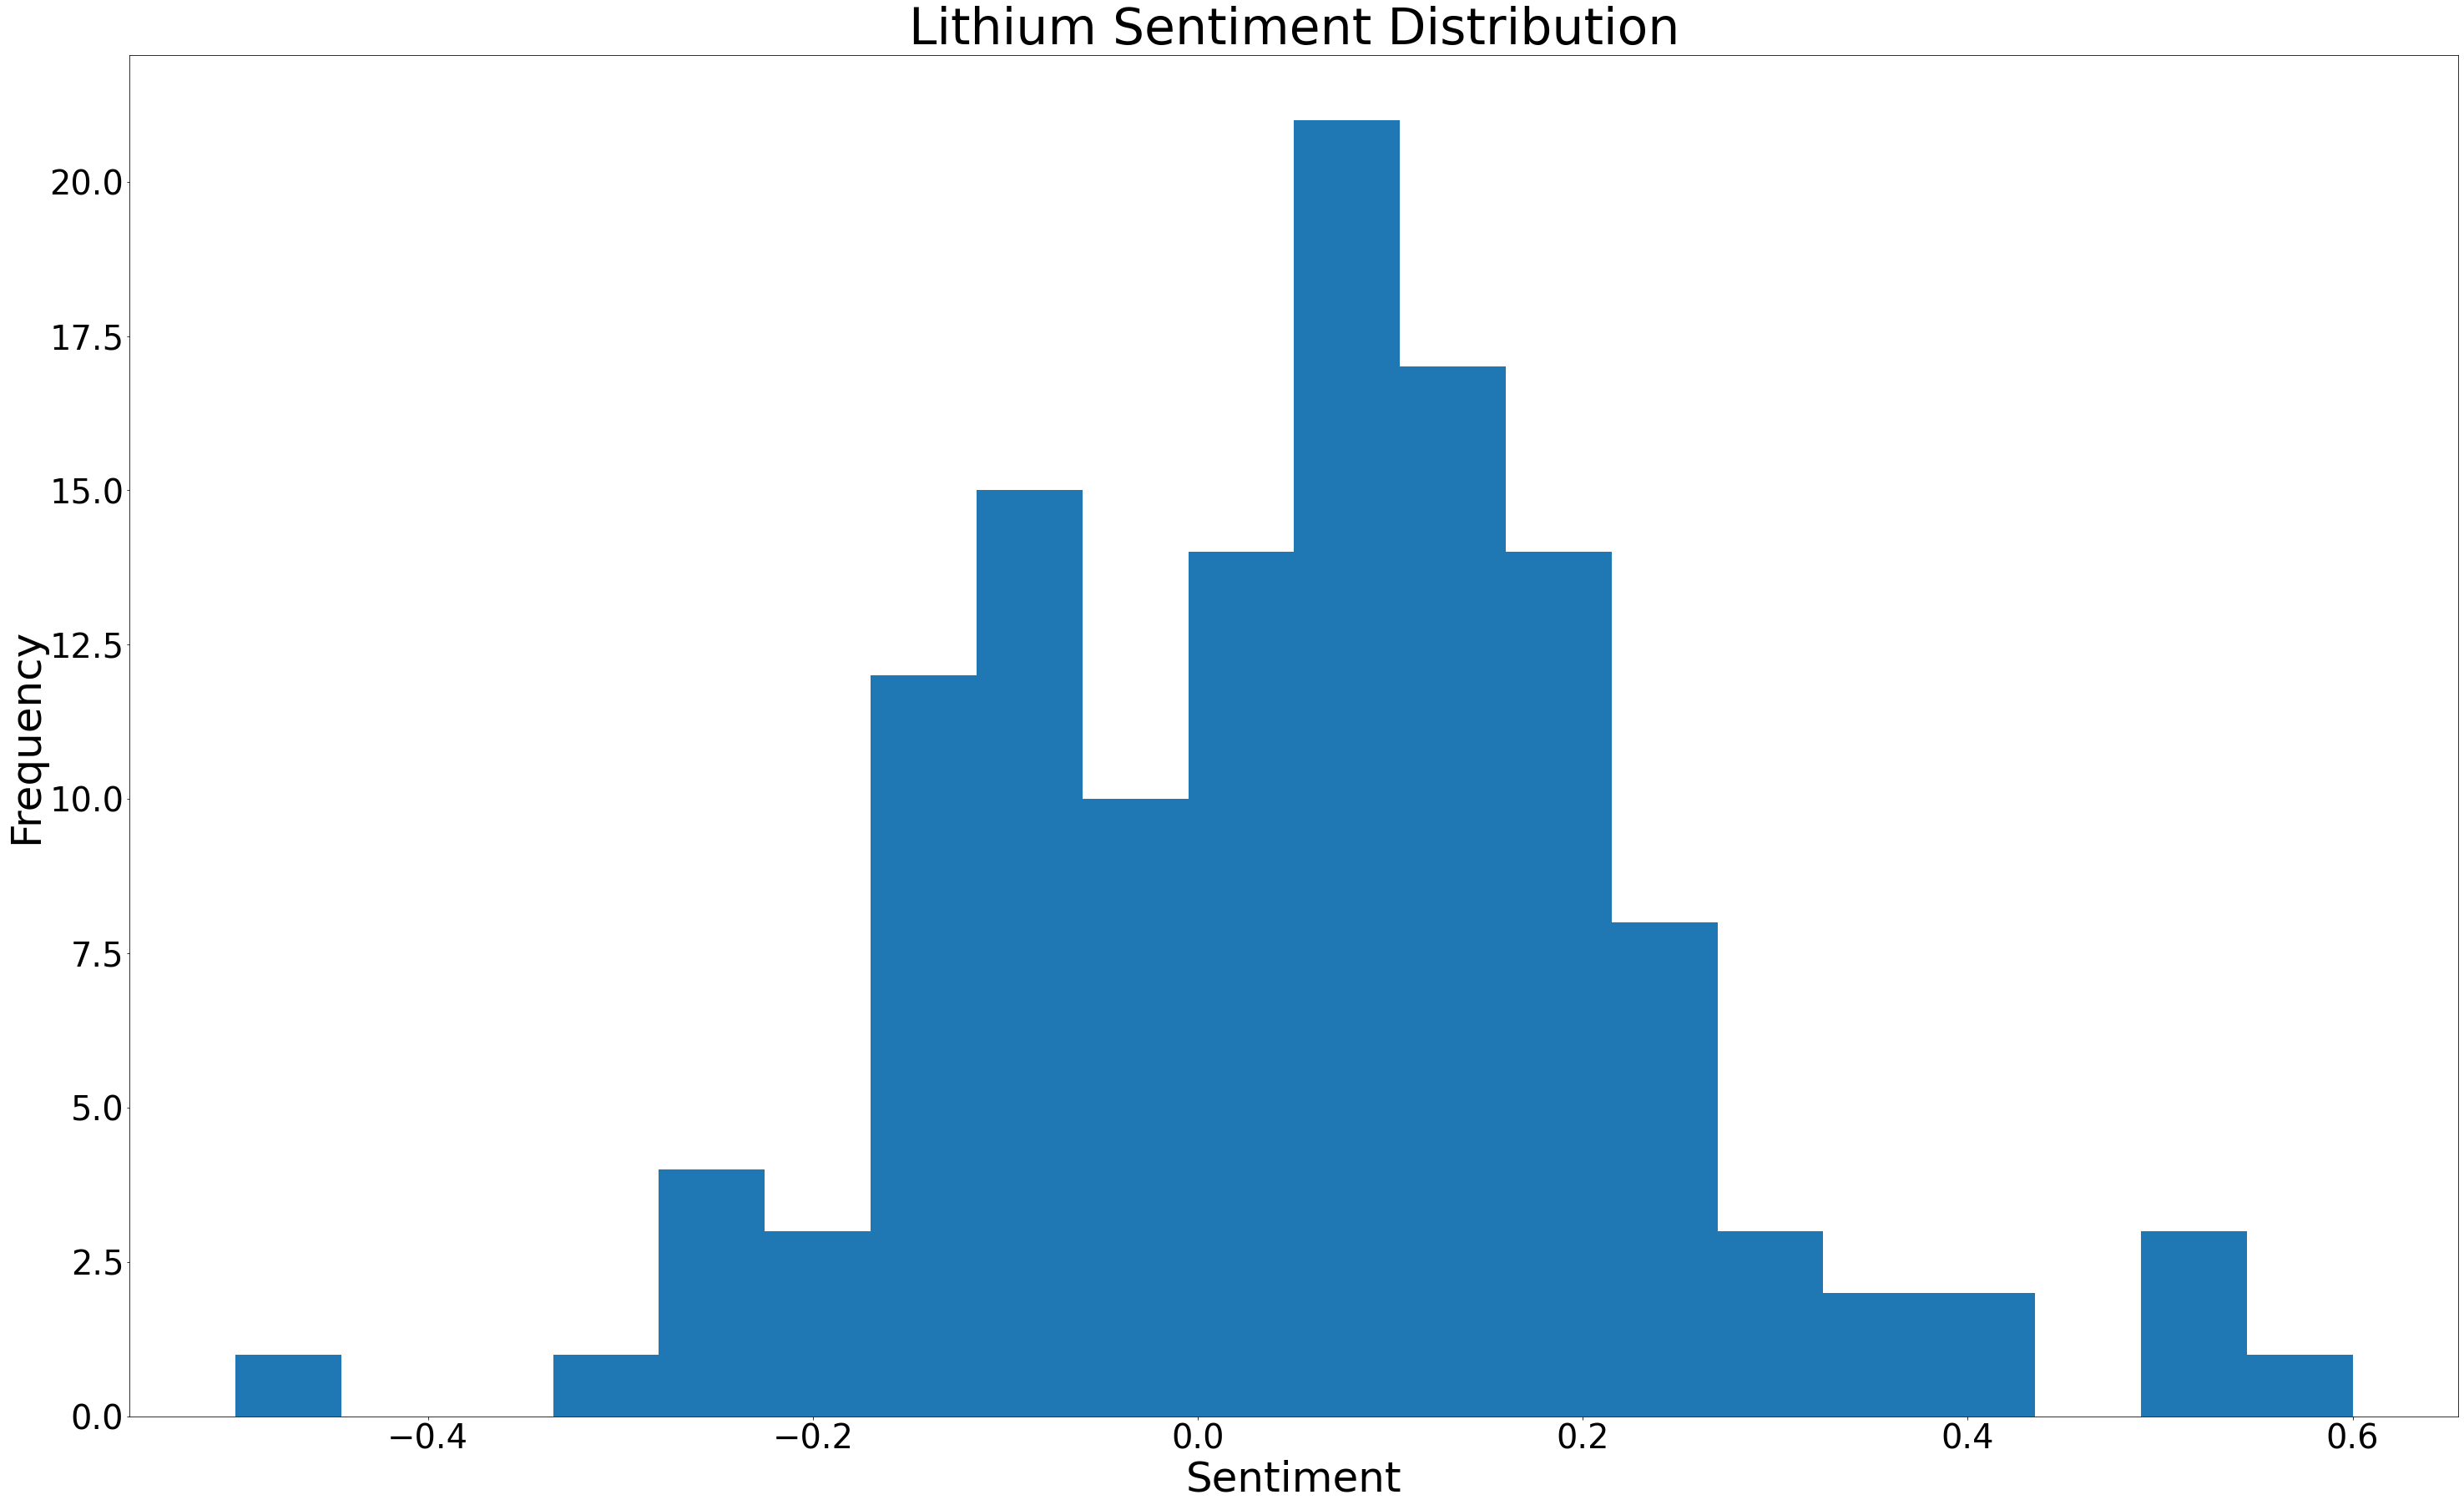

In [30]:
plt.figure(figsize=(50,30))
plt.xlabel('Sentiment', fontsize=50)
plt.xticks(fontsize=40)
plt.ylabel('Frequency', fontsize=50)
plt.yticks(fontsize=40)
plt.hist(sentiment_data.loc[sentiment_data["Word"] == "lithium", "Polarity"], bins=20)
plt.title('Lithium Sentiment Distribution', fontsize=60)
plt.show()

As a trader, these informations can be insightful. Maybe due to the development of the EV industry, that the needs for lithium ion battery also increase. With this information, a trader can trade lithium future contracts, or buy and hold stocks of the lithium producers like Albemarle and SQM on the NYSE.

#### Oil

The oil data show a sentiment mean of 0.048 with 47 records.

In [33]:
oil_sentiments = sentiment_data.loc[sentiment_data["Word"] == "oil","Polarity"]
oil_sentiments.describe()

count    47.000000
mean      0.048045
std       0.146520
min      -0.200000
25%      -0.066667
50%       0.058379
75%       0.101786
max       0.450000
Name: Polarity, dtype: float64

The data also show a major postive sentiment of oil with 53% of records. But due to the small sample size not much conclusion can be made.

In [39]:
negative = stats.percentileofscore(oil_sentiments, -0.05)
positive = 100 - stats.percentileofscore(oil_sentiments, 0.05)
neutral = 100 - negative - positive
print("Negative: ", negative)
print("Positive: ", positive)
print("Neutral: ", neutral)

Negative:  29.78723404255319
Positive:  53.191489361702125
Neutral:  17.02127659574468


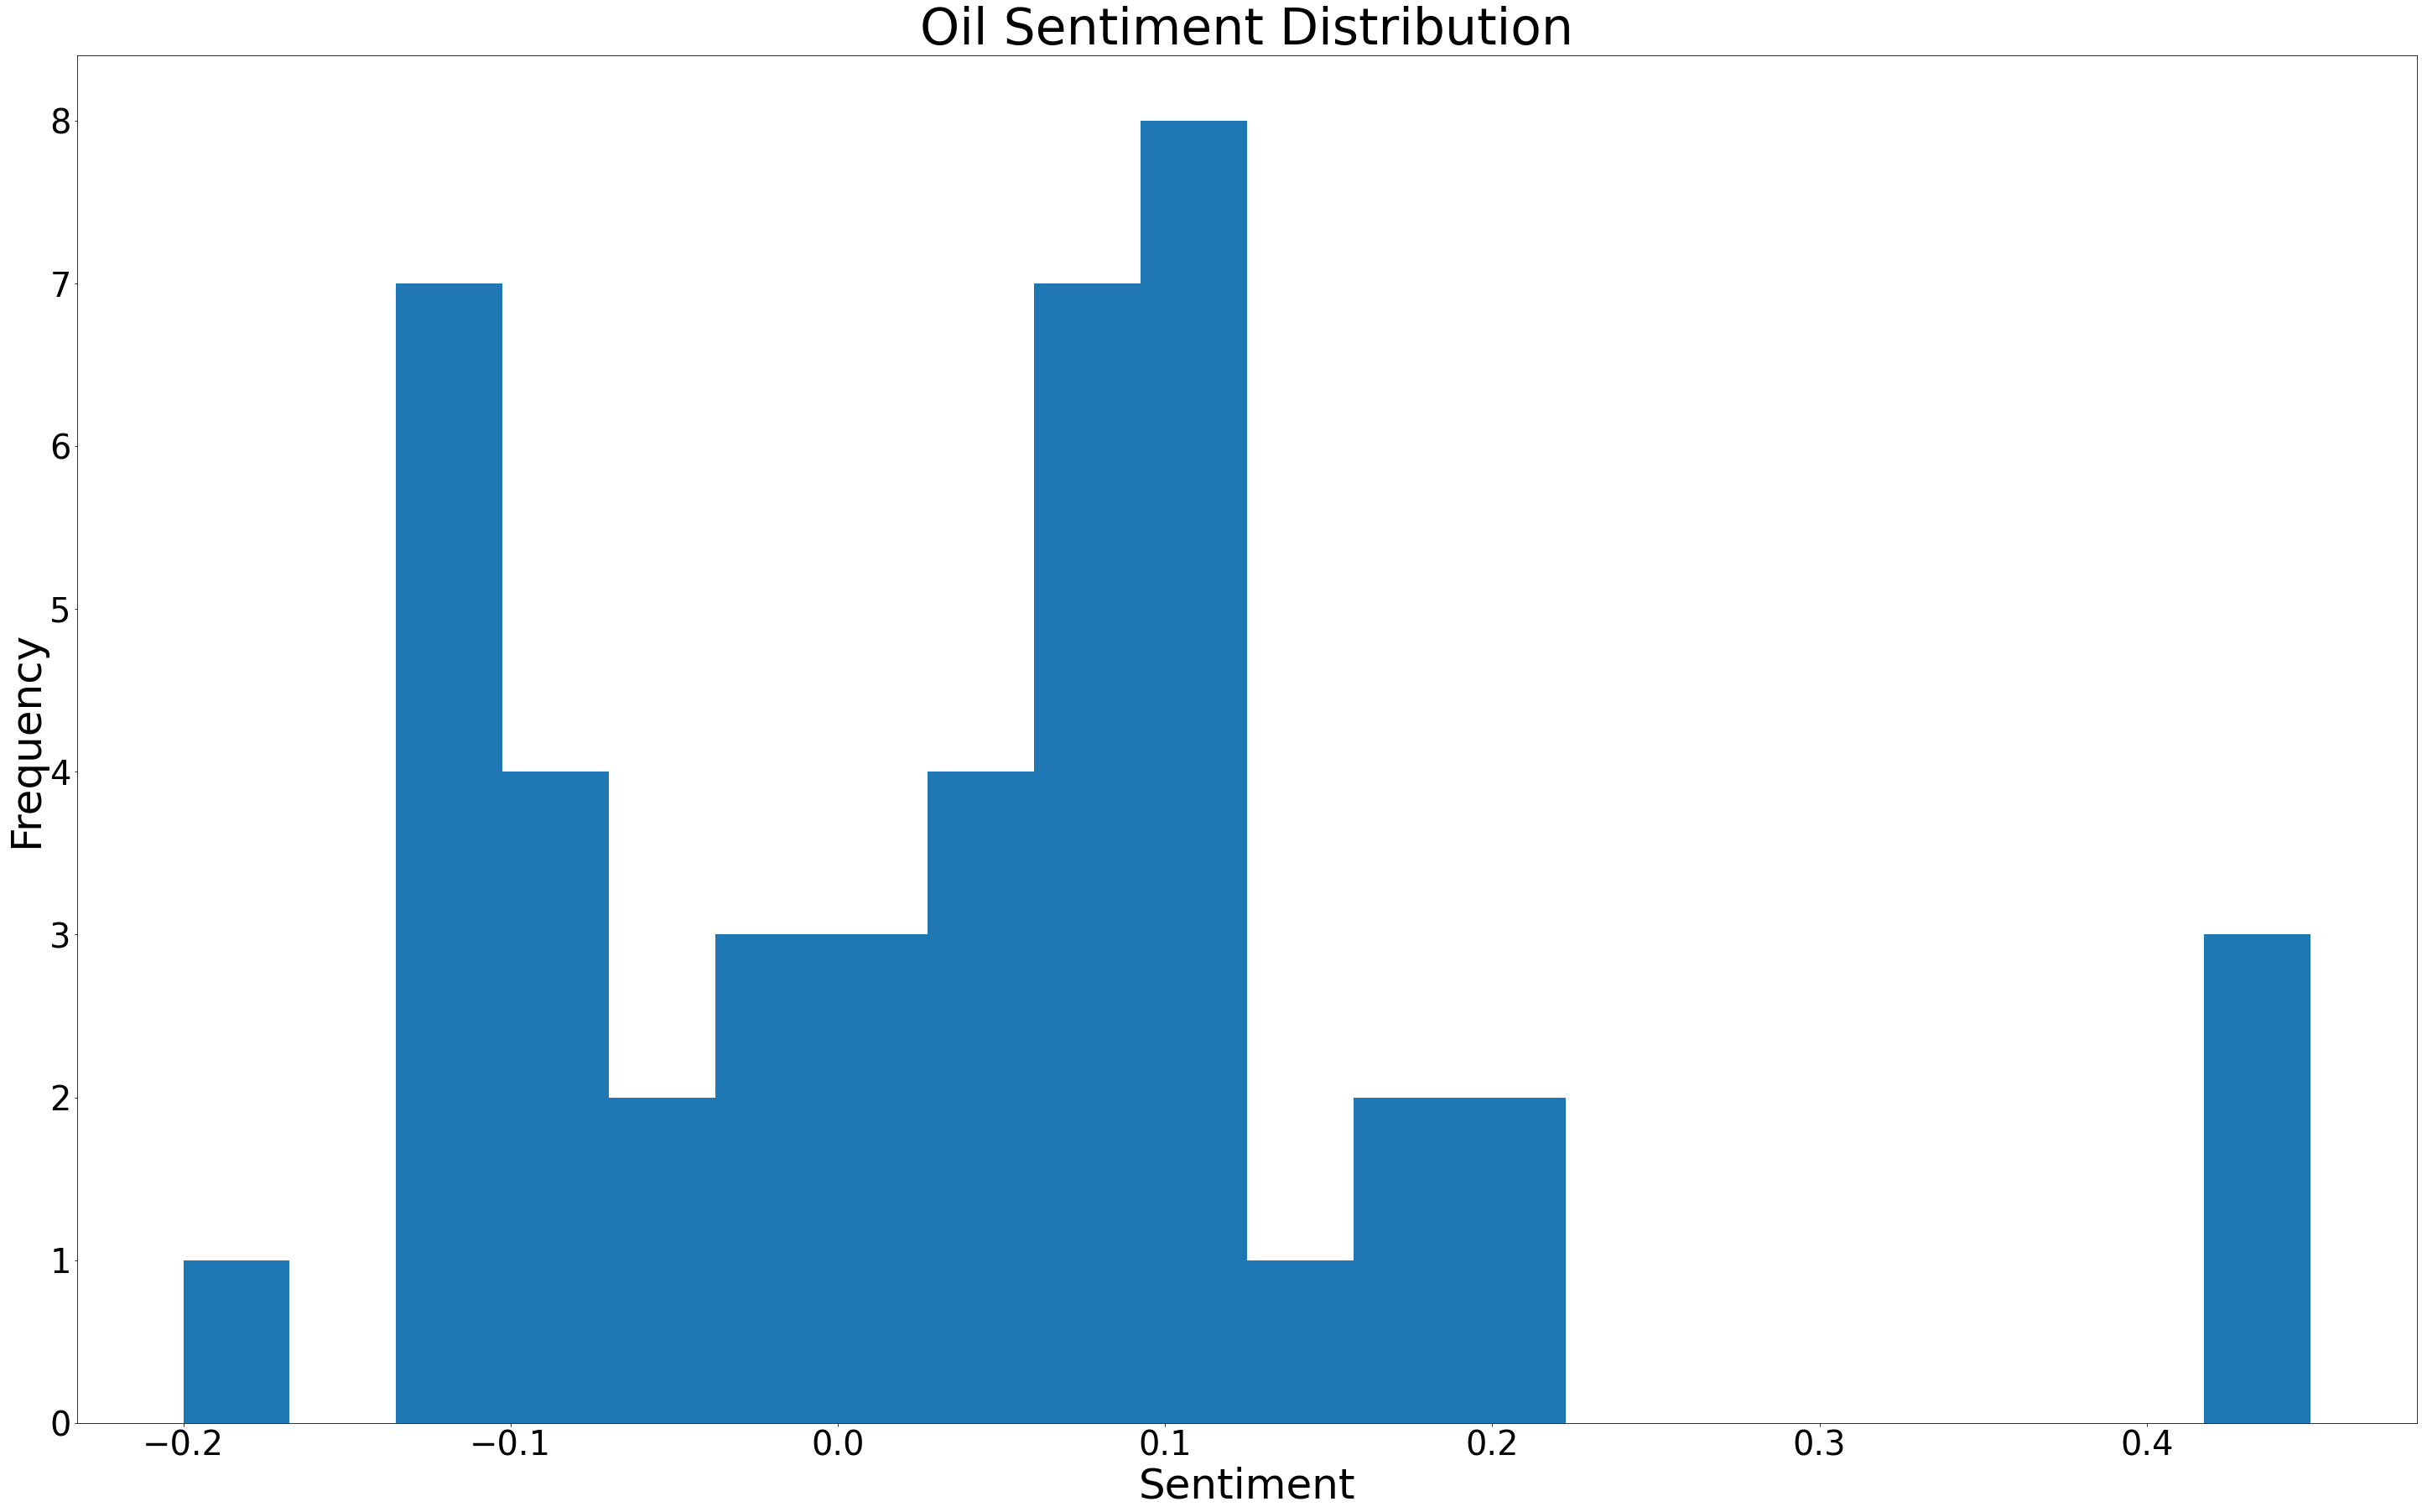

In [47]:
plt.figure(figsize=(50,30))
plt.xlabel('Sentiment', fontsize=50)
plt.xticks(fontsize=40)
plt.ylabel('Frequency', fontsize=50)
plt.yticks(fontsize=40)
plt.hist(oil_sentiments, bins=20)
plt.title('Oil Sentiment Distribution', fontsize=60)
plt.show()

#### Supply chain

The data show a sentiment mean of 0.067 with 390 records.

In [42]:
supply_chain_sentiments = sentiment_data.loc[sentiment_data["Word"] == "supply chain","Polarity"]
supply_chain_sentiments.describe()

count    390.000000
mean       0.067157
std        0.170301
min       -0.800000
25%       -0.031250
50%        0.041667
75%        0.142661
max        0.785714
Name: Polarity, dtype: float64

The data also shows a major positive views.

In [55]:
negative = stats.percentileofscore(supply_chain_sentiments, -0.05)
positive = 100 - stats.percentileofscore(supply_chain_sentiments, 0.05)
neutral = 100 - negative - positive
print("Negative: ", negative)
print("Positive: ", positive)
print("Neutral: ", neutral)

Negative:  17.94871794871795
Positive:  47.94871794871795
Neutral:  34.102564102564095


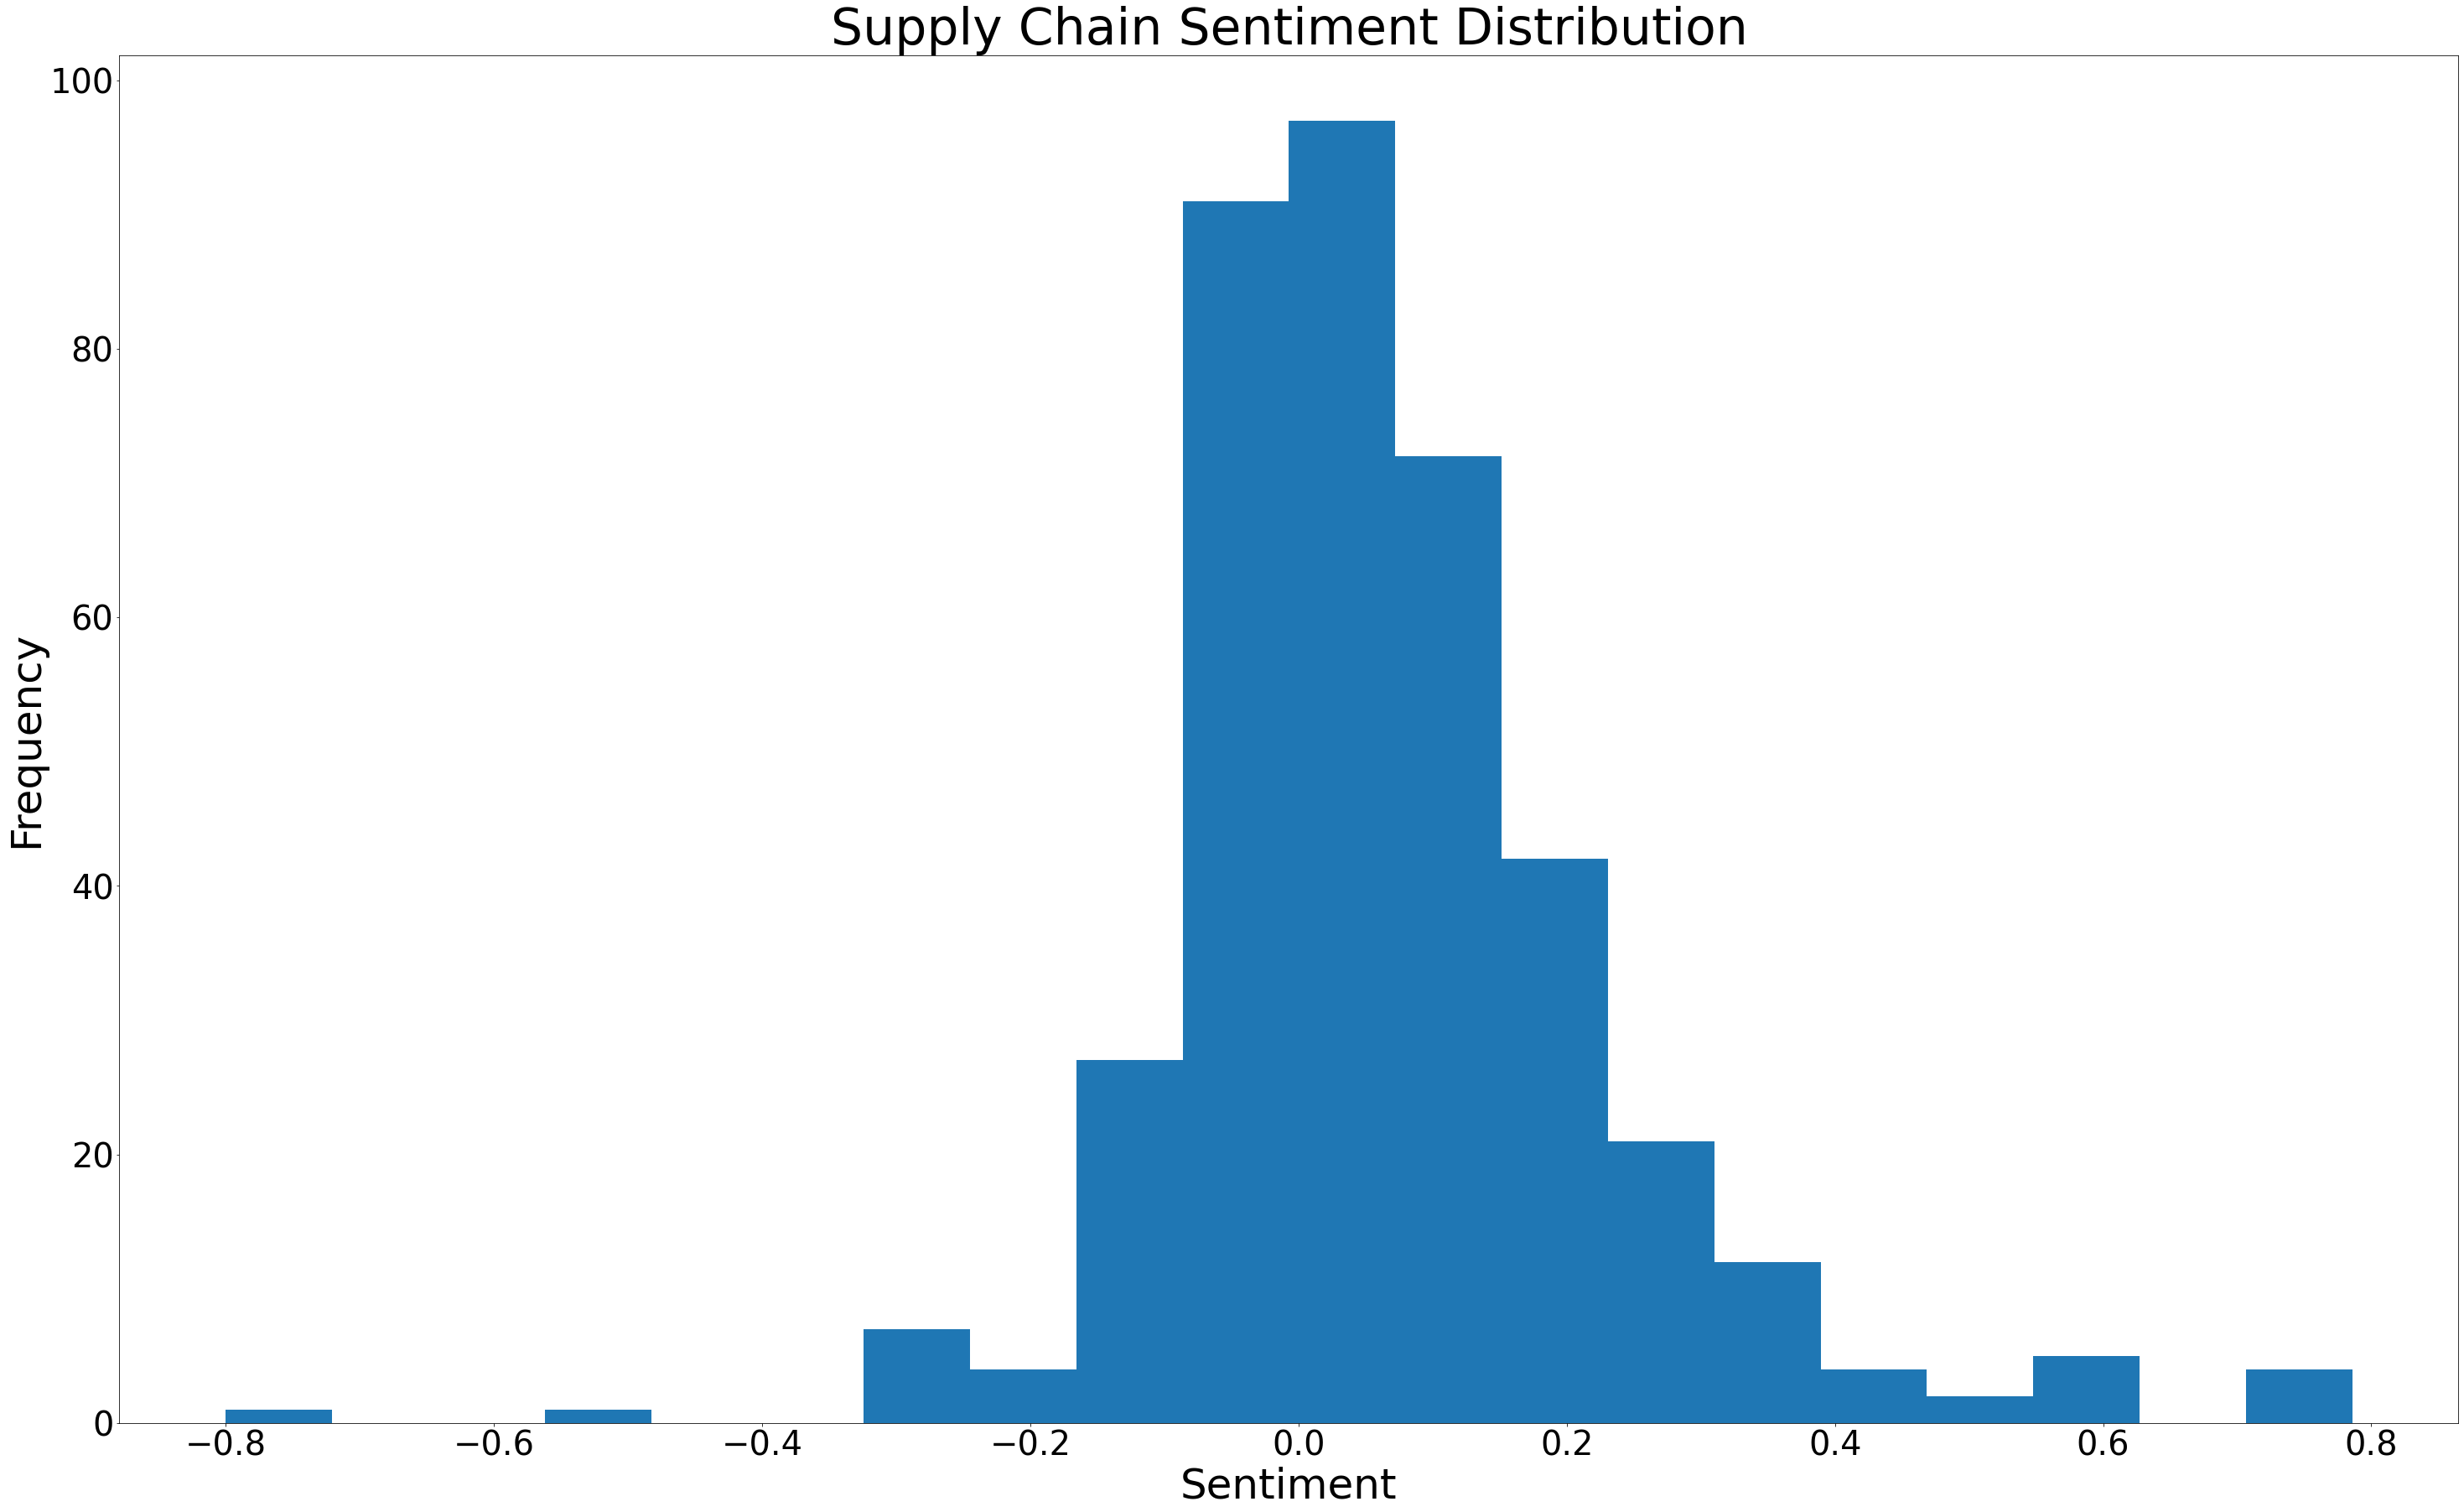

In [21]:
plt.figure(figsize=(50,30))
plt.xlabel('Sentiment', fontsize=50)
plt.xticks(fontsize=40)
plt.ylabel('Frequency', fontsize=50)
plt.yticks(fontsize=40)
plt.hist(supply_chain_sentiments, bins=20)
plt.title('Supply Chain Sentiment Distribution', fontsize=60)
plt.show()

Maybe because of the development of the new EV industry, which demands  components much more different than the traditional automotive supply chain. A fundamental trader can invest in the EV batteries manufacturer like Panasonic,... or other EV parts supplier like Gerneral Electric or Aptiv,..

#### Steel

The data show a sentiment mean of 0.091 with 79 records.

In [44]:
steel_sentiments = sentiment_data.loc[sentiment_data["Word"] == "steel","Polarity"]
steel_sentiments.describe()

count    79.000000
mean      0.090777
std       0.190635
min      -0.230769
25%      -0.050000
50%       0.085714
75%       0.215476
max       0.400000
Name: Polarity, dtype: float64

The data also shows major positive sentiments on steel.

In [45]:
negative = stats.percentileofscore(steel_sentiments, -0.05)
positive = 100 - stats.percentileofscore(steel_sentiments, 0.05)
neutral = 100 - negative - positive
print("Negative: ", negative)
print("Positive: ", positive)
print("Neutral: ", neutral)

Negative:  22.78481012658228
Positive:  54.43037974683544
Neutral:  22.784810126582286


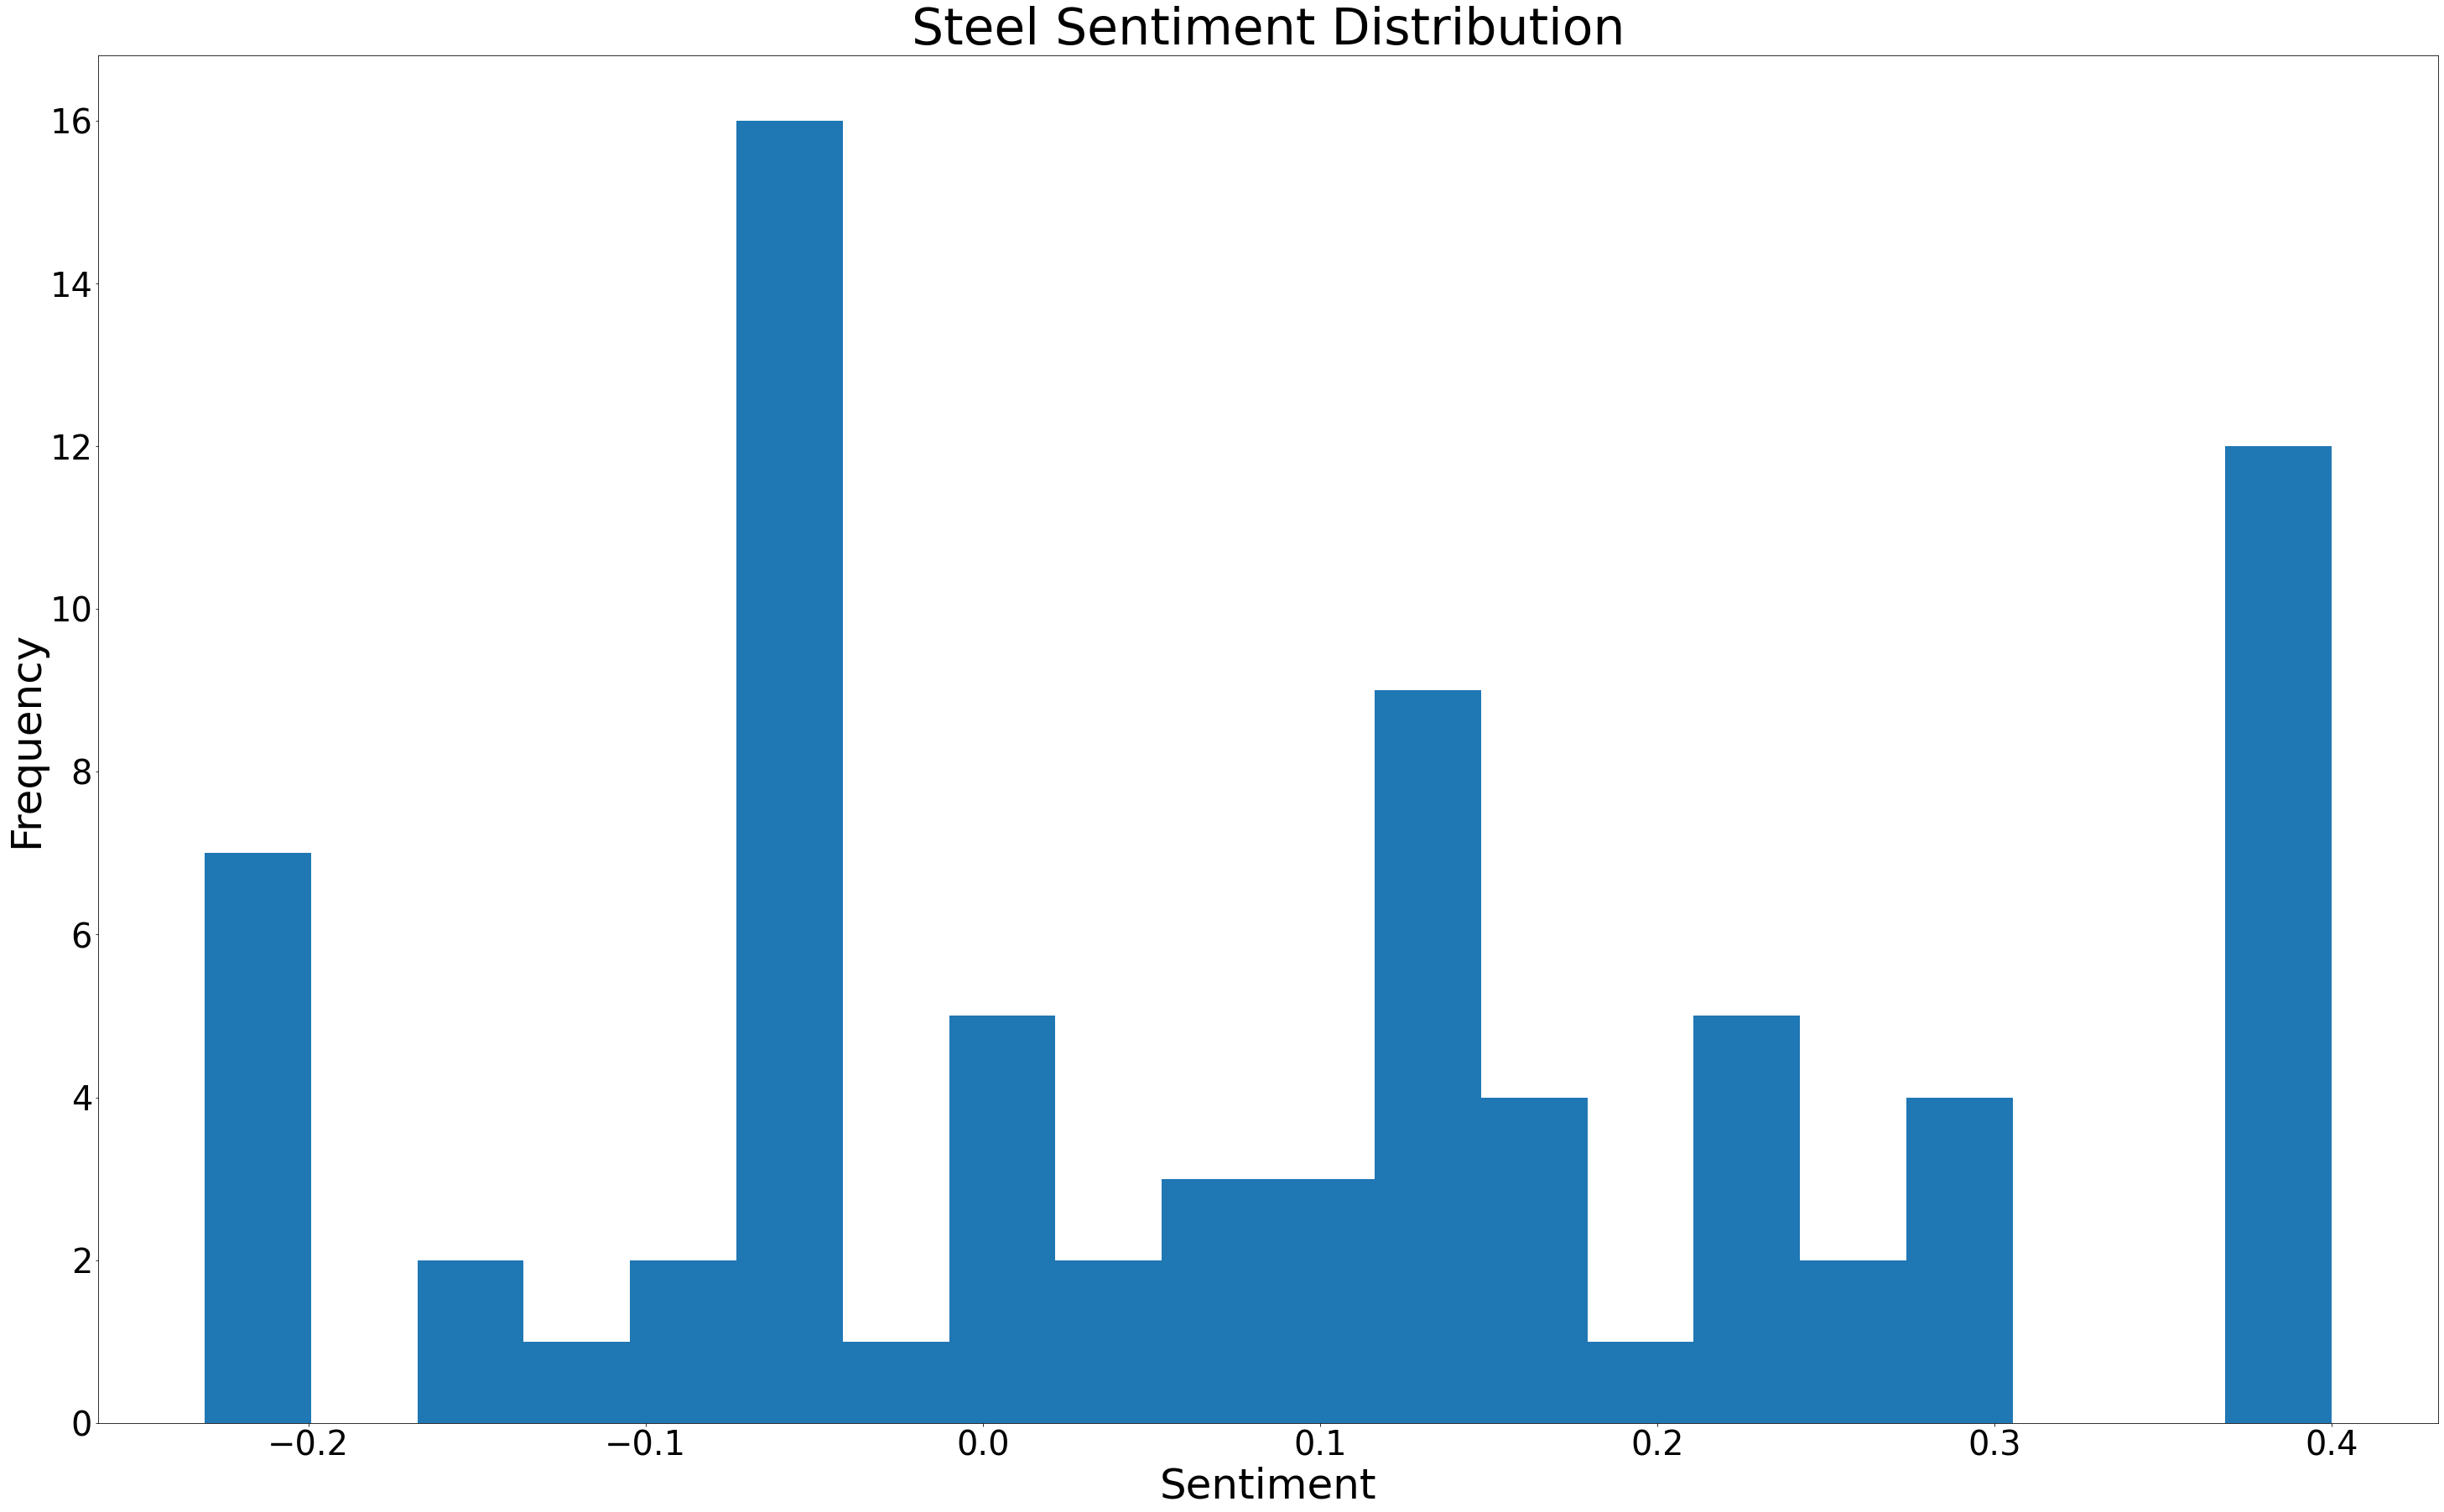

In [46]:
plt.figure(figsize=(50,30))
plt.xlabel('Sentiment', fontsize=50)
plt.xticks(fontsize=40)
plt.ylabel('Frequency', fontsize=50)
plt.yticks(fontsize=40)
plt.hist(steel_sentiments, bins=20)
plt.title('Steel Sentiment Distribution', fontsize=60)
plt.show()

All the automotive manufacturers heavily rely on the steel-producing industry. But the most of the big players that control the demands for steel are construction companies. So a trader can't decide to speculate or trade steel-related products or steel producers' stock from the informations of this data.

#### Aluminum

The aluminum sentiments show a mean of 0.045 with 42 records.

In [50]:
aluminum_sentiments = sentiment_data.loc[sentiment_data["Word"] == "aluminum","Polarity"]
aluminum_sentiments.describe()

count    42.000000
mean      0.045915
std       0.150618
min      -0.230769
25%      -0.059375
50%       0.059811
75%       0.133333
max       0.304762
Name: Polarity, dtype: float64

In [54]:
negative = stats.percentileofscore(aluminum_sentiments, -0.05)
positive = 100 - stats.percentileofscore(aluminum_sentiments, 0.05)
neutral = 100 - negative - positive
print("Negative: ", negative)
print("Positive: ", positive)
print("Neutral: ", neutral)

Negative:  26.19047619047619
Positive:  52.38095238095238
Neutral:  21.42857142857143


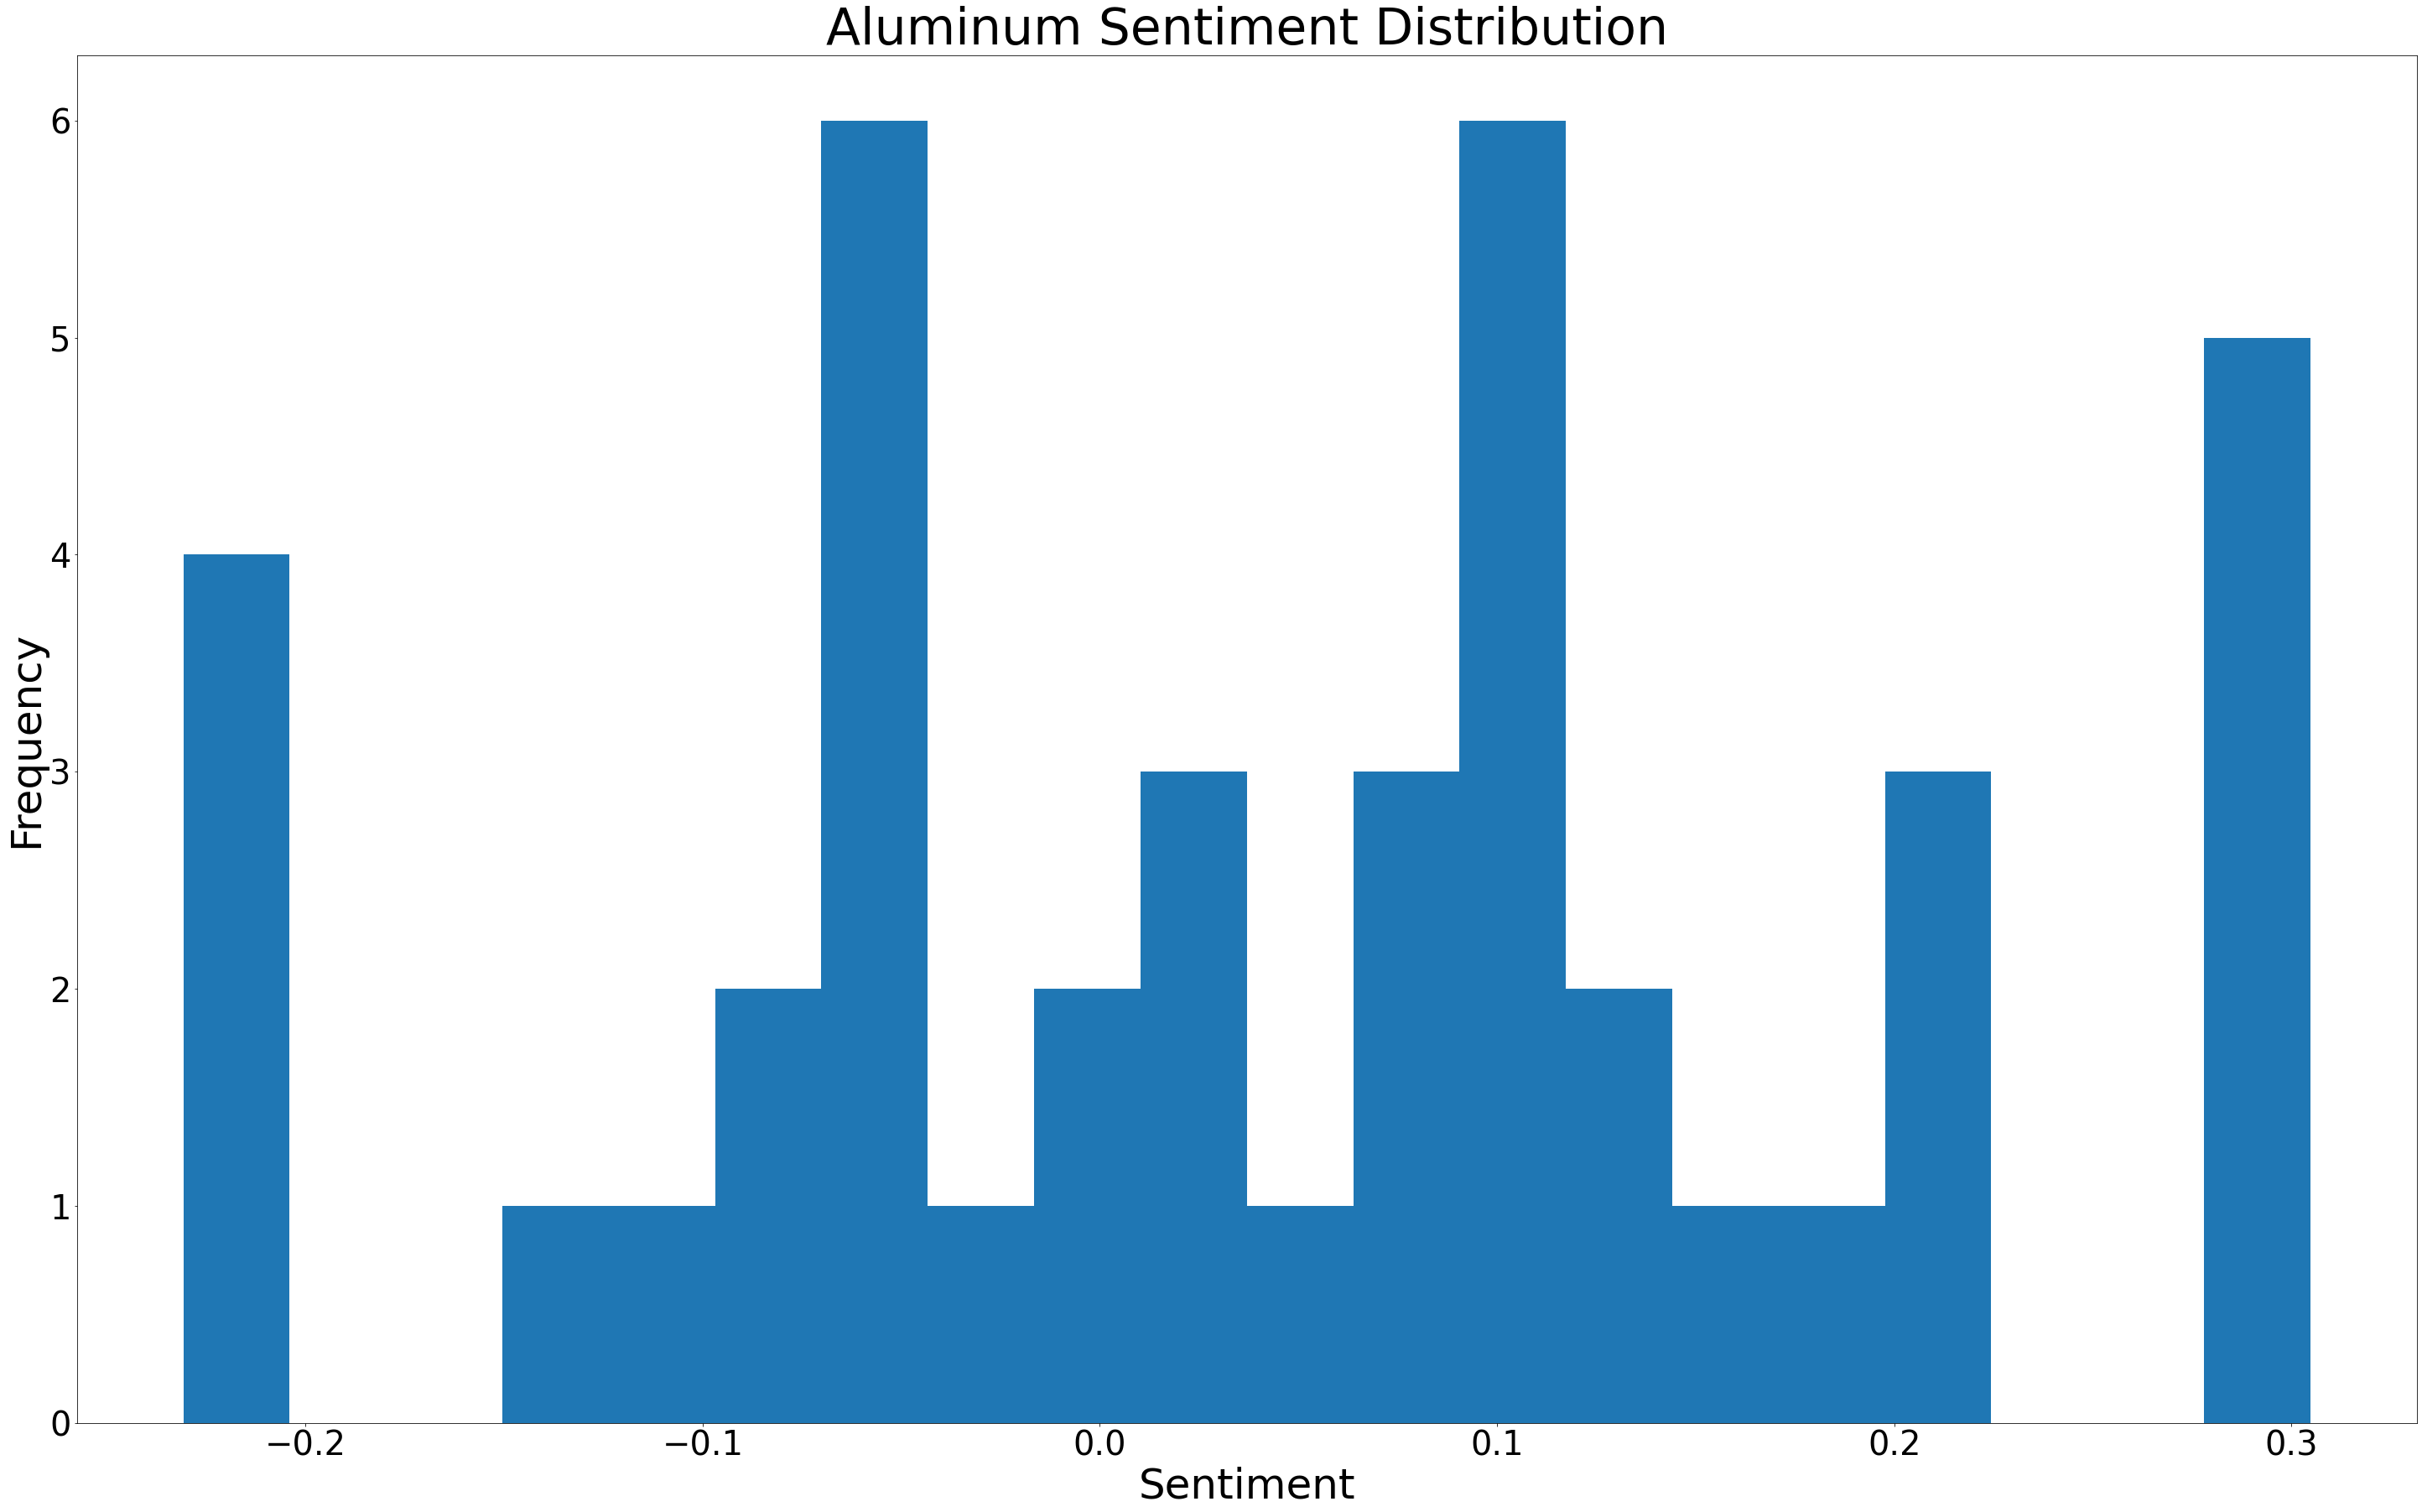

In [53]:
plt.figure(figsize=(50,30))
plt.xlabel('Sentiment', fontsize=50)
plt.xticks(fontsize=40)
plt.ylabel('Frequency', fontsize=50)
plt.yticks(fontsize=40)
plt.hist(aluminum_sentiments, bins=20)
plt.title('Aluminum Sentiment Distribution', fontsize=60)
plt.show()

Due to the small sample size, not much can be conclude from the results.